# Main file for thesis project

Ie the top level script which runs the whole `pic -> recognise -> aim gimbal -> repeat` show

In [1]:
#!/usr/bin/python3
# top level script to run the show
import time
import PIL.Image

import image_classifier
import gimbal_control as gc

## A Basic Loop

In [2]:
IC = image_classifier.ImageClassifier(
    graph_file='../Models/MobileNet_SSD_caffe/graph',
    label_file='../Models/MobileNet_SSD_caffe/categories.txt',
    class_of_interest='person')

In [14]:
while True:
    img_array = IC.take_picture_and_start_inference()
    output_dict, bb, bb_angles, inference_time_ms = IC.get_inference_result()

    if bb_angles == -1:
        print('-', end='')
        img = PIL.Image.fromarray(img_array)
        
    else:
        print('+', end='')
        # draw a box on the object
        (x1, y1), (x2, y2) = bb
        img = PIL.Image.fromarray(img_array)
        img = PIL.Image.fromarray(image_classifier.draw_bounding_box(y1, x1, y2, x2, img_array))
#         plt.imshow(img)
#         plt.show()

        # convert angles of object to centroids
        (phi_x1, phi_y1), (phi_x2, phi_y2) = bb_angles
        phi_yaw = (phi_x1 + phi_x2)/2
        phi_pitch = (phi_y1 + phi_y2)/2
        
        # get the current motor angles - need these to calculate offsets
        angles = gc.get_motor_angles()
        angles['pitch'] = -angles['pitch']
        print('gimbal = %d, obj = %d' % (angles['pitch'], phi_pitch))
            
#         print('phi_yaw = %d' % phi_yaw)
        gc.send_angle_command(0,
                              0,
                              phi_yaw/1.5 + angles['yaw'])
        # old integrator approach
#         x_target += (x1+x2)/2
#         x_target = max(-20, min(20, x_target))
#         gc.send_angle_command(0, 0, x_target)
#     time.sleep(0.05)

/usr/lib/python3/dist-packages/picamera/encoders.py:544: PiCameraResolutionRounded: frame size rounded up from 300x300 to 304x304
  width, height, fwidth, fheight)))
/usr/local/lib/python3.5/dist-packages/mvnc/mvncapi.py:418: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  tensor = numpy.fromstring(tensor.raw, dtype=numpy.float32)


+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 6
+gimbal = 0, obj = 6
+gimbal = 0, obj = 7
+gimbal = 0, obj = 6
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 6
+gimbal = 0, obj = 6
+gimbal = 0, obj = 6
+gimbal = 0, obj = 6
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 6
+gimbal = 0, obj = 7
+gimbal = 0, obj = 8
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 8
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 6
+gimbal = 0, obj = 6
+gimbal = 0, obj = 2
+gimbal = 0, obj = 0
+gimbal = 0, obj = 0
+gimbal = 0, obj = 0
+gimbal = 0, obj = 6
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 6
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7
+gimbal = 0, obj = 7


KeyboardInterrupt: 

/usr/lib/python3/dist-packages/picamera/encoders.py:544: PiCameraResolutionRounded: frame size rounded up from 300x300 to 304x304
  width, height, fwidth, fheight)))
/usr/local/lib/python3.5/dist-packages/mvnc/mvncapi.py:418: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  tensor = numpy.fromstring(tensor.raw, dtype=numpy.float32)


+

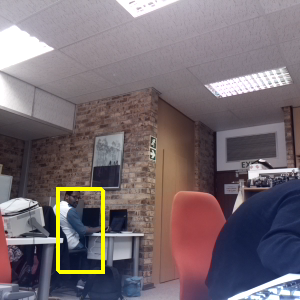

In [12]:
img_array = IC.take_picture_and_start_inference()
output_dict, bb, bb_angles, inference_time_ms = IC.get_inference_result()

if bb_angles == -1:
    print('-', end='')
    img = PIL.Image.fromarray(img_array)

else:
    print('+', end='')
    # draw a box on the object
    (x1, y1), (x2, y2) = bb
    img = PIL.Image.fromarray(img_array)
    img = PIL.Image.fromarray(image_classifier.draw_bounding_box(y1, x1, y2, x2, img_array))

img